<h2 align="center" style="color:Green">Insurance Premium Estimator</h2>


- 1. Dependencies Installation and Imports
- 2. Data Loading
- 3. Data Exploration and Analysis
- 4. Data Preprocessing
- 5. Model Building
- 6. Model Evaluation
- 7. Model Optimization
- 8. Error Analysis

<h2 align="center" style="color:Green">Importing Required Dependencies</h2>

In [2]:
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error, confusion_matrix, classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler


<h2 align="center" style="color:Green">Data Loading</h2>

In [3]:
df = pd.read_excel('premiums_young_with_gr.xlsx')
df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount,Genetical_Risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,2
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,1


In [4]:
df.shape

(20096, 14)

In [5]:
df.columns

Index(['Age', 'Gender', 'Region', 'Marital_status', 'Number Of Dependants',
       'BMI_Category', 'Smoking_Status', 'Employment_Status', 'Income_Level',
       'Income_Lakhs', 'Medical History', 'Insurance_Plan',
       'Annual_Premium_Amount', 'Genetical_Risk'],
      dtype='object')

In [6]:
df.columns = df.columns.str.replace(' ','_').str.lower()
df.columns

Index(['age', 'gender', 'region', 'marital_status', 'number_of_dependants',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'income_lakhs', 'medical_history', 'insurance_plan',
       'annual_premium_amount', 'genetical_risk'],
      dtype='object')

<h2 align="center" style="color:Green">Exploratory Data Analysis & Data Cleaning</h2>

### Handle Missing Values

In [7]:
# Checking for null values
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           2
employment_status        1
income_level             4
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

In [8]:
# Dropping NA values as those are very less
df.dropna(inplace=True)
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

### Handle Duplicates

In [9]:
# Handling Missing Values
df.duplicated().sum()

0

In [10]:
# if we update dataset and if we get any duplicate values, we drop before. For future proof
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

## 1. Numeric Columns

### Univariate Analysis: Numeric Columns

#### Box plots for numeric columns

In [11]:

df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,20090.000000,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.718019,22.510851,8142.096267,2.503932
std,2.294052,0.940713,23.420493,2749.906347,1.710203
min,18.000000,-3.000000,1.000000,3501.000000,0.000000
25%,19.000000,0.000000,6.000000,6022.250000,1.000000
50%,22.000000,0.000000,16.000000,7939.000000,3.000000
75%,23.000000,1.000000,31.000000,9561.000000,4.000000
max,25.000000,3.000000,790.000000,18186.000000,5.000000


In [12]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount',
       'genetical_risk'],
      dtype='object')

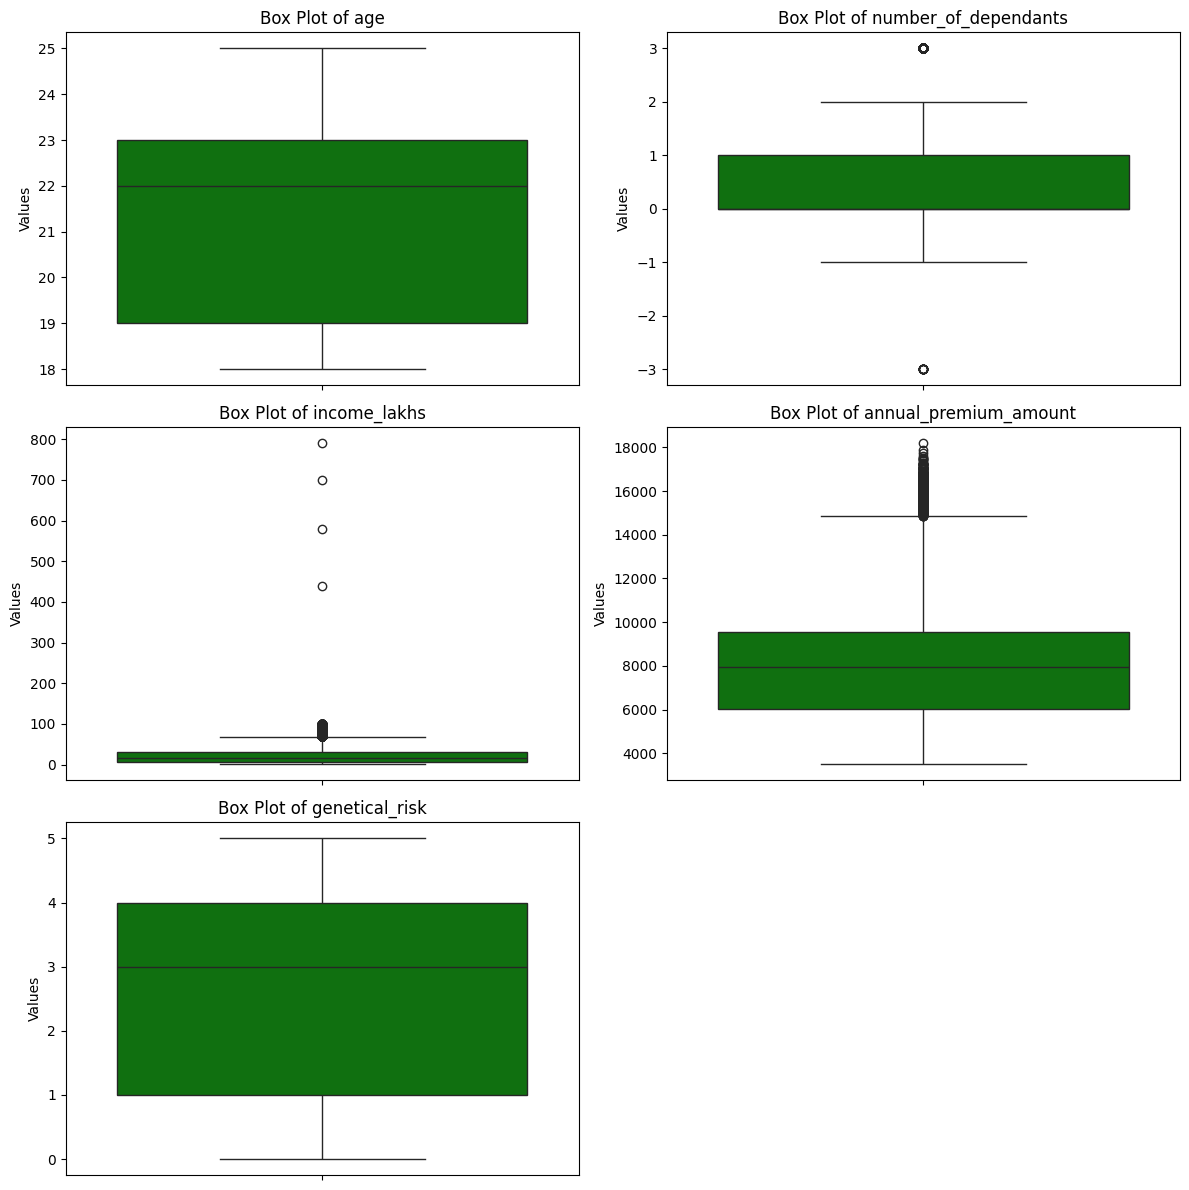

In [13]:
# Set up the figure with subplots (3 rows, 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Flatten the axes array to easily index
axes = axes.flatten()

# Loop through the columns and plot
for i, column in enumerate(numeric_columns):
    sns.boxplot(ax=axes[i], data=df[column], color='green')
    axes[i].set_title(f'Box Plot of {column}')
    axes[i].set_ylabel('Values')

# Hide the empty subplot in the 3rd row, 2nd column
axes[-1].axis('off')

# Adjust the layout
plt.tight_layout()
plt.show()

- Here we can see there are few outliers in age, number_of_dependants, income_lakhs. Now we can treat outliers

<h2 align="center" style="color:green">Data Preprocessing</h2>

#### Data Cleaning: number_of_dependants

In [14]:
df[df['number_of_dependants'] < 0]['number_of_dependants'].unique()

array([-3, -1])

In [15]:
df['number_of_dependants'] = df['number_of_dependants'].abs()
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,20090.000000,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.722598,22.510851,8142.096267,2.503932
std,2.294052,0.937200,23.420493,2749.906347,1.710203
min,18.000000,0.000000,1.000000,3501.000000,0.000000
25%,19.000000,0.000000,6.000000,6022.250000,1.000000
50%,22.000000,0.000000,16.000000,7939.000000,3.000000
75%,23.000000,1.000000,31.000000,9561.000000,4.000000
max,25.000000,3.000000,790.000000,18186.000000,5.000000


### Outlier Treatment: Age Column

In [16]:
df[df['age']>100]['age'].unique()

array([], dtype=int64)

In [17]:
df = df[df['age']<=100]
df[df['age']>100]

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk


### Outlier Treatment: Income Column

In [18]:
def get_iqr_bounds(col):
    Q1, Q3 = col.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

lower, upper = get_iqr_bounds(df['income_lakhs'])
lower, upper


(-31.5, 68.5)

In [19]:
df[df.income_lakhs>upper].shape

(1295, 14)

There are many legitimate records that we will get rid of if we use IQR bounds method. Hence after discussion with business we decided to use a simple quantile bound 

In [20]:
quantile_thresold = df.income_lakhs.quantile(0.999)
quantile_thresold

100.0

In [21]:
df[df.income_lakhs>quantile_thresold].shape

(4, 14)

In [22]:
df = df[df.income_lakhs<=quantile_thresold].copy()
df.shape

(20086, 14)

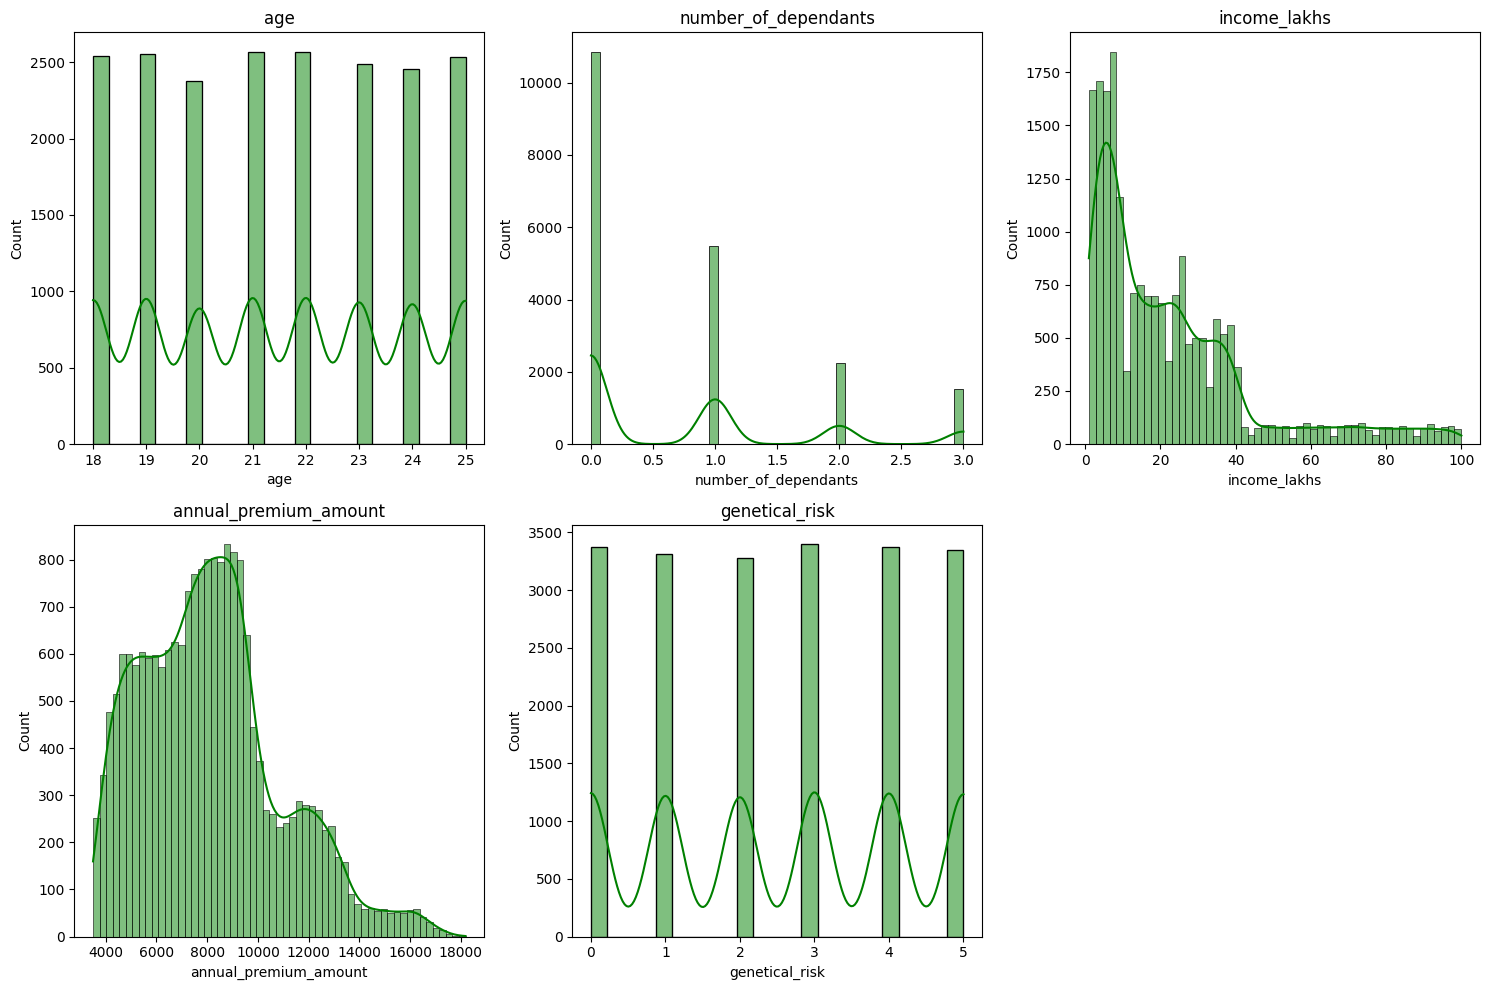

In [23]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))  # Adjust the size to ensure plots are not squeezed

for i, column in enumerate(numeric_columns):
    # Locating the correct subplot using integer division and modulus
    ax = axs[i // 3, i % 3]  # Row index is i//3, column index is i%3
    sns.histplot(df[column], kde=True, ax=ax, color ='green')
    ax.set_title(column)

# If the last subplot axis is unused, you can turn it off
if len(numeric_columns) % 3 != 0:
    for j in range(len(numeric_columns), 6):  # This will disable any unused subplots
        axs.flat[j].set_visible(False)

plt.tight_layout()
plt.show()

### Bivariate Analysis: Numeric Columns

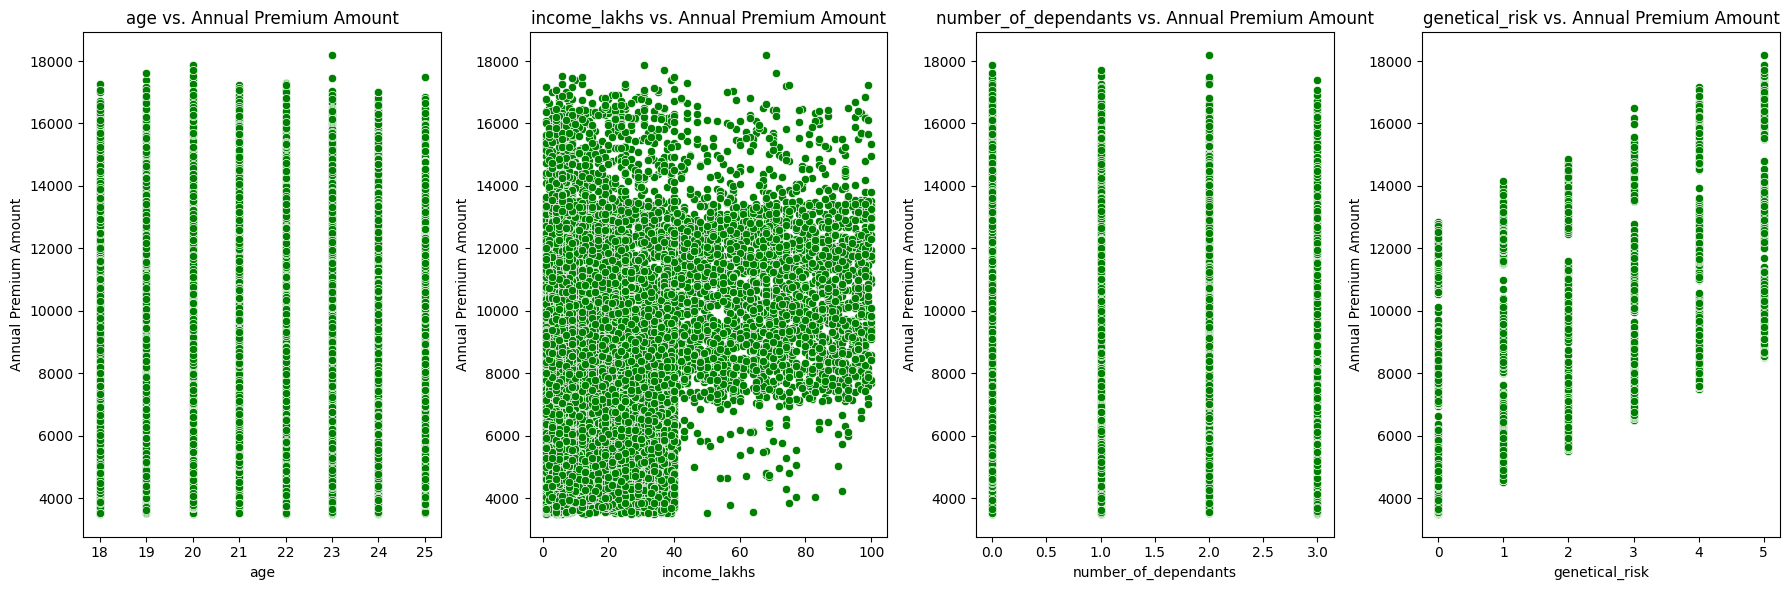

In [24]:
numeric_features = ['age', 'income_lakhs', 'number_of_dependants', 'genetical_risk']

fig, axes = plt.subplots(1, len(numeric_features), figsize=(18, 6))  # Adjust figure size as necessary

for ax, column in zip(axes, numeric_features):
    sns.scatterplot(x=df[column], y=df['annual_premium_amount'], ax=ax, color='green')
    ax.set_title(f'{column} vs. Annual Premium Amount')
    ax.set_xlabel(column)
    ax.set_ylabel('Annual Premium Amount')

plt.tight_layout()  # Adjust layout
plt.show()

## 2. Categorical Columns

In [25]:
categorical_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status', 'income_level', 'medical_history', 'insurance_plan']
for col in categorical_cols:
    print(col, ":", df[col].unique())

gender : ['Male' 'Female']
region : ['Northeast' 'Northwest' 'Southeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Overweight' 'Underweight' 'Normal' 'Obesity']
smoking_status : ['Regular' 'No Smoking' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Self-Employed' 'Freelancer' 'Salaried']
income_level : ['> 40L' '<10L' '10L - 25L' '25L - 40L']
medical_history : ['High blood pressure' 'No Disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease' 'Diabetes' 'Diabetes & Thyroid'
 'Heart disease' 'Thyroid' 'High blood pressure & Heart disease']
insurance_plan : ['Silver' 'Bronze' 'Gold']


In [26]:
df['smoking_status'].replace({
    'Not Smoking': 'No Smoking',
    'Does Not Smoke': 'No Smoking',
    'Smoking=0': 'No Smoking'
}, inplace=True)

df['smoking_status'].unique()

array(['Regular', 'No Smoking', 'Occasional'], dtype=object)

### Univariate Analysis

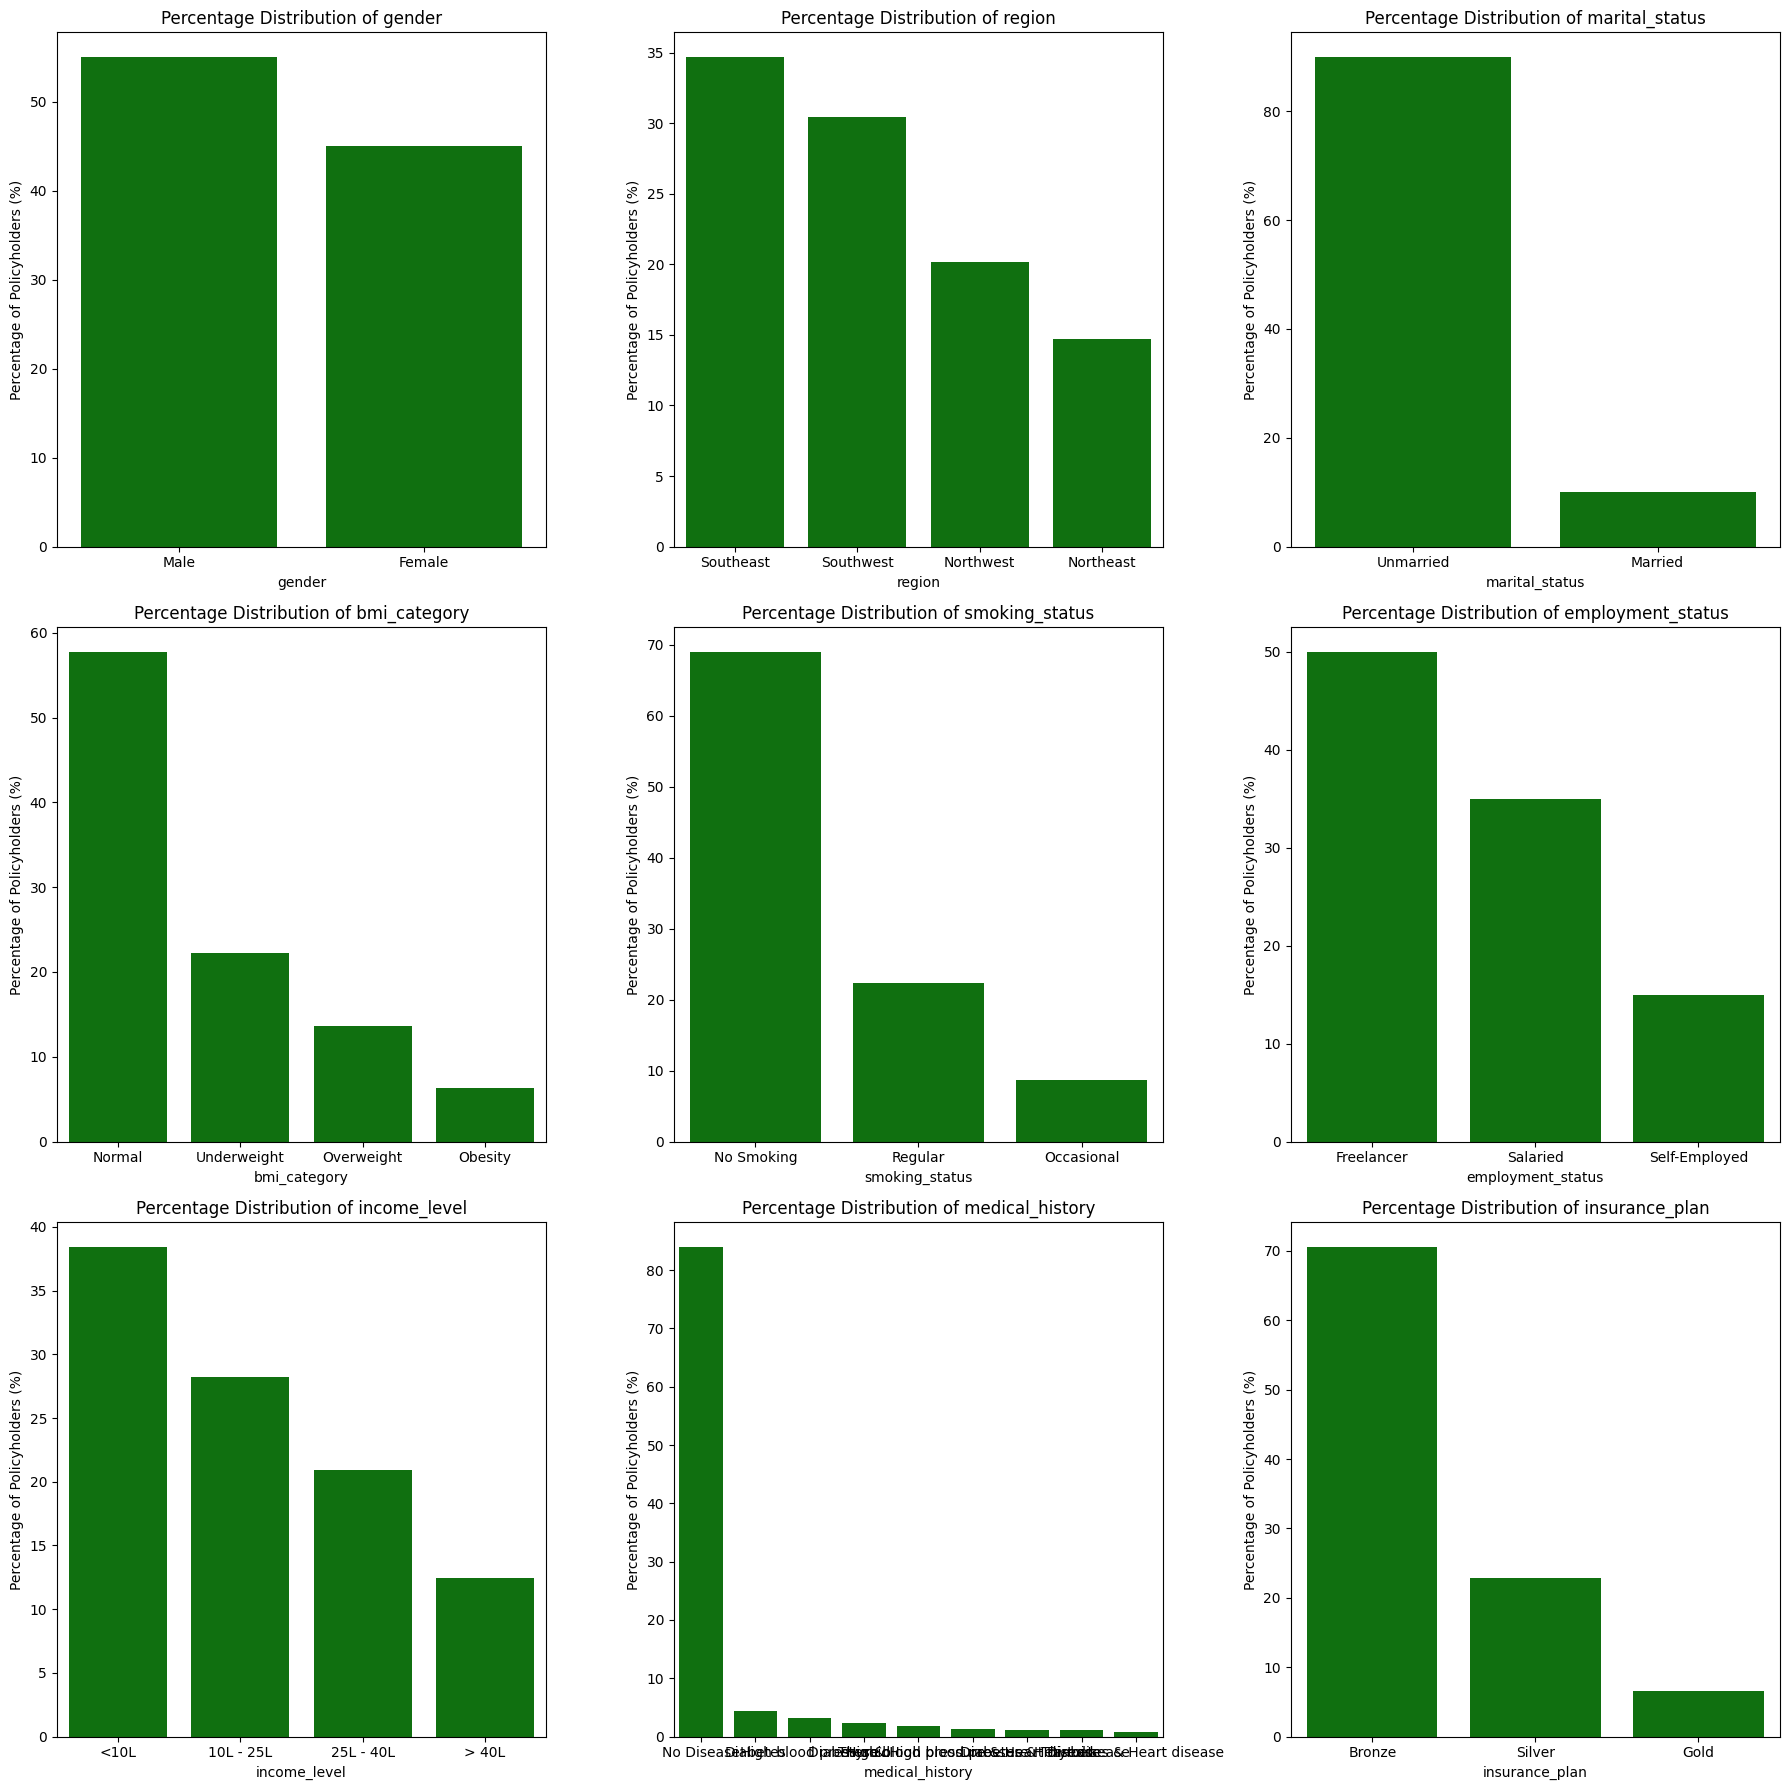

In [27]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))  # Adjust figure size as necessary
axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

for ax, column in zip(axes, categorical_cols):
    # Calculate the percentage distribution of each category
    category_counts = df[column].value_counts(normalize=True) * 100  # normalize=True gives the relative frequencies
    
    # Plotting the distribution using barplot
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax, color = 'green')
    ax.set_title(f'Percentage Distribution of {column}')
    ax.set_ylabel('Percentage of Policyholders (%)')
    ax.set_xlabel(column)  # Set xlabel to the column name for clarity

plt.tight_layout()  # Adjusts plot parameters for better fit in the figure window
plt.show()

### Bivariate Analysis

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L         4508   326     828
25L - 40L         3382   209     608
<10L              6172   404    1145
> 40L              115   366    2023


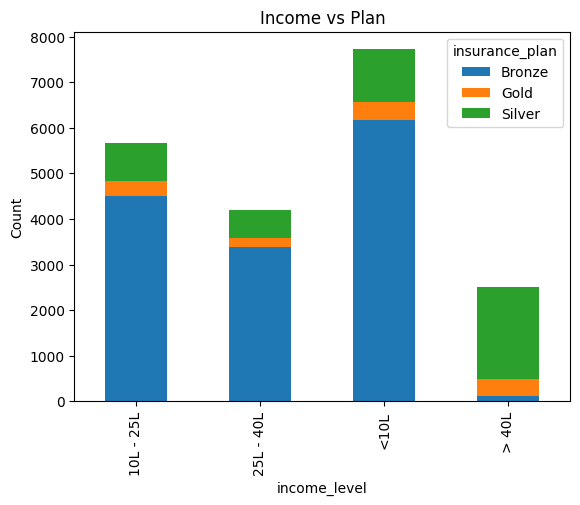

In [28]:
crosstab = pd.crosstab(df['income_level'], df['insurance_plan'])
print(crosstab)

crosstab.plot(kind='bar', stacked=True)
plt.title('Income vs Plan')
plt.ylabel('Count')
plt.show()

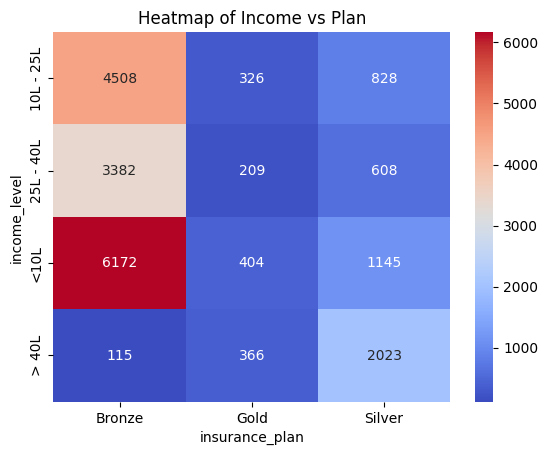

In [29]:
sns.heatmap(crosstab, annot=True, cmap='coolwarm',fmt="d")
plt.title('Heatmap of Income vs Plan')
plt.show()

<h2 align="center" style="color:green">Feature Engineering</h2>

### Calculate Risk Score

In [30]:
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure":6,
    "thyroid": 5,
    "no disease": 0,
    "none":0
}

df[['disease1', 'disease2']] = df['medical_history'].str.split(" & ", expand=True).apply(lambda x: x.str.lower())
df['disease1'].fillna('none', inplace=True)
df['disease2'].fillna('none', inplace=True)
df['total_risk_score'] = 0

for disease in ['disease1', 'disease2']:
    df['total_risk_score'] += df[disease].map(risk_scores)

max_score = df['total_risk_score'].max()
min_score = df['total_risk_score'].min()
df['normalized_risk_score'] = (df['total_risk_score'] - min_score) / (max_score - min_score)
df.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3,no disease,none,0,0.000000


### Encode Text Columns

In [31]:
df['insurance_plan'] = df['insurance_plan'].map({'Bronze': 1, 'Silver': 2, 'Gold': 3})

In [32]:
df['income_level'] = df['income_level'].map({'<10L':1, '10L - 25L': 2, '25L - 40L':3, '> 40L':4})

In [33]:
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
df = pd.get_dummies(df, columns=nominal_cols, drop_first=True, dtype=int)
df.head(3)

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,High blood pressure,2,13365,4,high blood pressure,none,...,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,No Disease,2,11050,3,no disease,none,...,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,No Disease,2,11857,4,no disease,none,...,1,0,1,0,0,0,0,1,1,0


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20086 entries, 0 to 20095
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              20086 non-null  int64  
 1   number_of_dependants             20086 non-null  int64  
 2   income_level                     20086 non-null  int64  
 3   income_lakhs                     20086 non-null  int64  
 4   medical_history                  20086 non-null  object 
 5   insurance_plan                   20086 non-null  int64  
 6   annual_premium_amount            20086 non-null  int64  
 7   genetical_risk                   20086 non-null  int64  
 8   disease1                         20086 non-null  object 
 9   disease2                         20086 non-null  object 
 10  total_risk_score                 20086 non-null  int64  
 11  normalized_risk_score            20086 non-null  float64
 12  gender_Male       

## Feature Selection

### Calculate VIF for Multicolinearity

In [35]:
columns = df.columns

/var/folders/b3/2x3zcx9n041_c_wb1nq8mrpc0000gn/T/ipykernel_47674/952712649.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df[columns].corr()


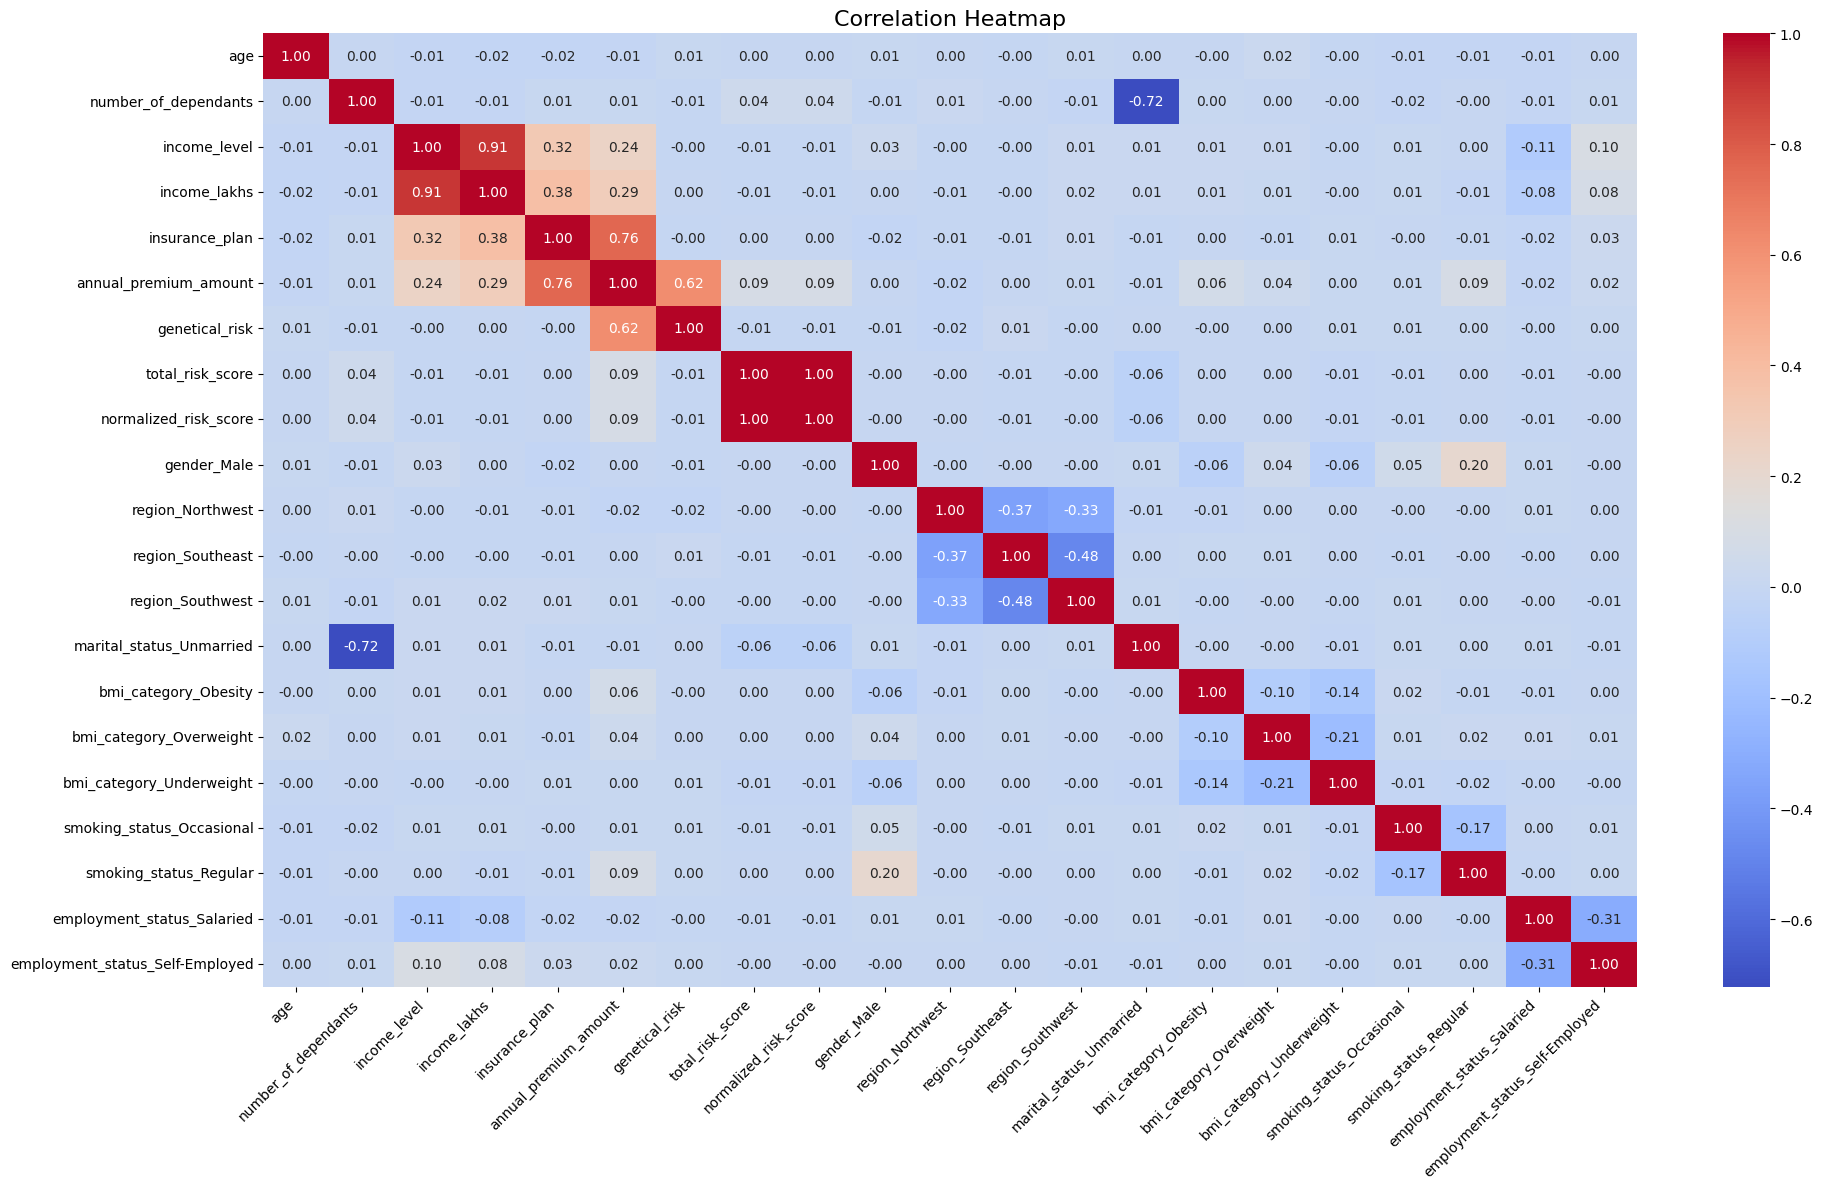

In [36]:

# Calculate the correlation matrix
correlation_matrix = df[columns].corr()

# Plot the heatmap
plt.figure(figsize=(20, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')  # Added color map and formatted float display
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Correlation Heatmap', fontsize=16)
plt.tight_layout()
plt.show()

In [37]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Assuming 'df' is your DataFrame with the relevant columns
columns_for_model = [
    'age', 'number_of_dependants', 'income_level', 'income_lakhs',
    'insurance_plan', 'normalized_risk_score',
    'gender_Male', 'region_Northwest', 'region_Southeast',
    'region_Southwest', 'marital_status_Unmarried', 'bmi_category_Obesity',
    'bmi_category_Overweight', 'bmi_category_Underweight',
    'smoking_status_Occasional', 'smoking_status_Regular',
    'employment_status_Salaried', 'employment_status_Self-Employed', 'genetical_risk'
]

# Define features and target variable
X = df[columns_for_model].copy()  # Make a copy of the DataFrame to avoid SettingWithCopyWarning
y = df['annual_premium_amount']

# Define columns to scale
cols_to_scale = ['age', 'number_of_dependants', 'income_level', 'income_lakhs', 'insurance_plan', 'genetical_risk']

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Use .loc to safely modify the selected columns
X.loc[:, cols_to_scale] = scaler.fit_transform(X.loc[:, cols_to_scale])

# Get summary statistics of the transformed data
X.describe()


,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed,genetical_risk
count,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000
mean,0.499211,0.240914,0.357994,0.216064,0.179578,0.092076,0.550383,0.201284,0.346958,0.304590,0.899881,0.063527,0.136513,0.222493,0.086379,0.223589,0.350045,0.149955,0.500777
std,0.327750,0.312413,0.347481,0.219516,0.300051,0.230016,0.497467,0.400970,0.476014,0.460245,0.300167,0.243914,0.343341,0.415931,0.280929,0.416660,0.476996,0.357036,0.342037
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.142857,0.000000,0.000000,0.050505,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000
50%,0.571429,0.000000,0.333333,0.151515,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.600000
75%,0.714286,0.333333,0.666667,0.303030,0.500000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.800000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [38]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [39]:
calculate_vif(X)

,Column,VIF
0,age,3.154599
1,number_of_dependants,1.930428
2,income_level,11.928708
3,income_lakhs,11.876413
4,insurance_plan,1.592966
5,normalized_risk_score,1.154501
6,gender_Male,2.311831
7,region_Northwest,2.154355
8,region_Southeast,2.990493
9,region_Southwest,2.744620


In [40]:
calculate_vif(X.drop('income_level', axis="columns"))

,Column,VIF
0,age,3.153255
1,number_of_dependants,1.927788
2,income_lakhs,2.294155
3,insurance_plan,1.587868
4,normalized_risk_score,1.154453
5,gender_Male,2.301658
6,region_Northwest,2.153423
7,region_Southeast,2.989301
8,region_Southwest,2.743932
9,marital_status_Unmarried,7.985337


In [41]:
X_reduced = X.drop('income_level', axis="columns")

<h2 align="center" style="color:green">Model Training</h2>

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.30, random_state=10)

# shape of the X_train, X_test, y_train, y_test features
print("x train: ",X_train.shape)
print("x test: ",X_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (14060, 18)
x test:  (6026, 18)
y train:  (14060,)
y test:  (6026,)


### Linear Regression Model

In [43]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
test_score = model_lr.score(X_test, y_test)
train_score = model_lr.score(X_train, y_train)
train_score, test_score

(0.988297900194864, 0.9887263253056615)

In [44]:
y_pred = model_lr.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("Linear Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

Linear Regression ==> MSE:  85732.34377930441 RMSE:  292.800860277603


In [45]:
X_test.shape

(6026, 18)

In [46]:
np.set_printoptions(suppress=True, precision=6)
model_lr.coef_

array([  -7.229032,   19.536182,   -1.264528, 7001.125261, 1109.148365,
          8.177988,    1.677353,   -3.275327,    6.317095,   16.068972,
        812.844929,  400.375598,  107.529819,  205.069661,  610.98328 ,
          0.038784,   -5.242018, 4996.988728])

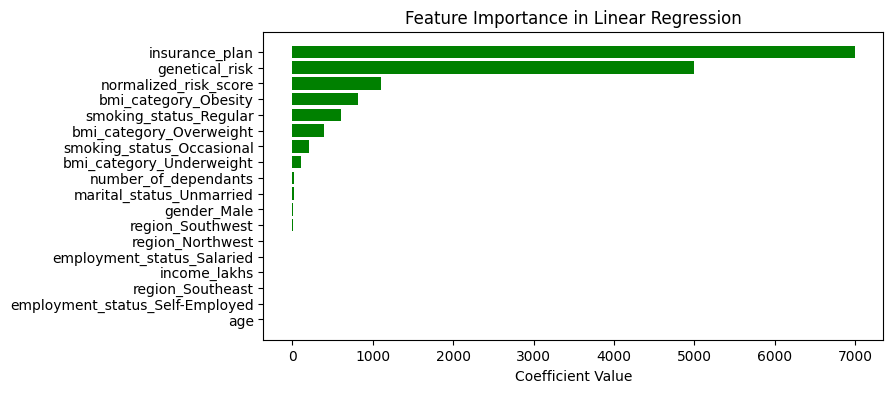

In [47]:
feature_importance = model_lr.coef_

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='green')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.show()

### Ridge Regression Model

In [48]:
model_rg = Ridge(alpha=1)
model_rg.fit(X_train, y_train)
test_score = model_rg.score(X_test, y_test)
train_score = model_rg.score(X_train, y_train)
train_score, test_score

(0.9882972960153418, 0.9887275909694276)

In [49]:
y_pred = model_rg.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("Ridge Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

Ridge Regression ==> MSE:  85722.71885007394 RMSE:  292.78442385153267


### XGBoost 

In [50]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor(n_estimators=20, max_depth=3)
model_xgb.fit(X_train, y_train)
model_xgb.score(X_test, y_test)

0.9876989126205444

In [51]:
y_pred = model_xgb.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("XGBoost Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

XGBoost Regression ==> MSE:  93545.5234375 RMSE:  305.85212675000315


In [52]:
model_xgb = XGBRegressor()
param_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}
random_search = RandomizedSearchCV(model_xgb, param_grid, n_iter=10, cv=3, scoring='r2', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
random_search.best_score_

0.9879226088523865

In [53]:
random_search.best_params_

{'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}

In [54]:
best_model = random_search.best_estimator_

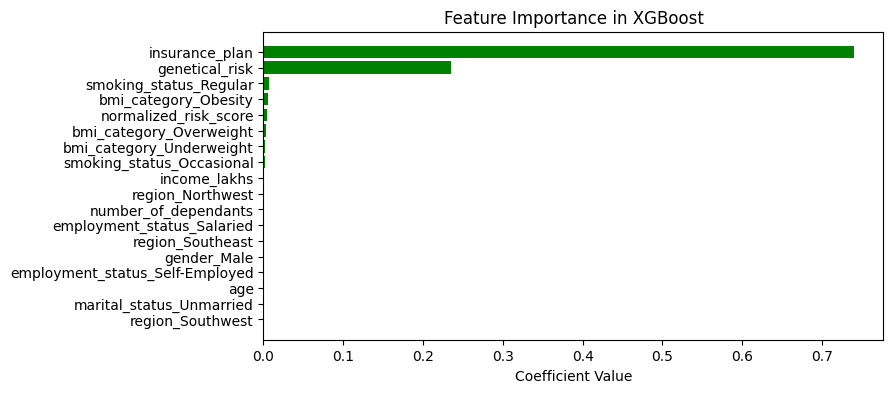

In [55]:
feature_importance = best_model.feature_importances_

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='green')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in XGBoost')
plt.show()

<h2 align="center" style="color:green">Error Analysis</h2>

In [56]:
y_pred = best_model.predict(X_test)

residuals = y_pred - y_test
residuals_pct = (residuals / y_test) * 100

results_df = pd.DataFrame({
    'actual': y_test, 
    'predicted': y_pred, 
    'diff': residuals, 
    'diff_pct': residuals_pct
})
results_df.head()

,actual,predicted,diff,diff_pct
12774,6238,6104.117676,-133.882324,-2.146238
14758,9462,9593.652344,131.652344,1.391380
13205,5152,5619.506348,467.506348,9.074269
14278,6988,7377.886230,389.886230,5.579368
19351,4917,5109.857422,192.857422,3.922258


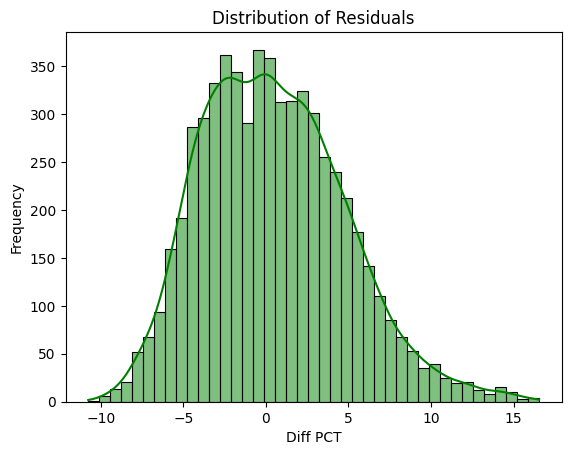

In [57]:
sns.histplot(results_df['diff_pct'], kde=True, color = 'green')
plt.title('Distribution of Residuals')
plt.xlabel('Diff PCT')
plt.ylabel('Frequency')
plt.show()

In [58]:
X_test.shape

(6026, 18)

In [59]:
extreme_error_threshold = 10  # You can adjust this threshold based on your domain knowledge or requirements
extreme_results_df = results_df[np.abs(results_df['diff_pct']) > extreme_error_threshold]
extreme_results_df.head()

,actual,predicted,diff,diff_pct
12669,3985,4487.946777,502.946777,12.620998
2918,4517,5070.301270,553.301270,12.249309
17084,3562,4097.839844,535.839844,15.043230
7181,3630,4097.839844,467.839844,12.888150
12285,3532,4097.839844,565.839844,16.020381


In [60]:
extreme_results_df.shape

(150, 4)

In [61]:
extreme_errors_pct = extreme_results_df.shape[0]*100/X_test.shape[0]
extreme_errors_pct

2.489213408562894

In [62]:
extreme_results_df[abs(extreme_results_df.diff_pct)>50].sort_values("diff_pct",ascending=False)

,actual,predicted,diff,diff_pct


In [63]:
extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df.head(2)

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed,genetical_risk
12669,0.857143,0.0,0.000000,0.0,0.0,1,0,1,0,1,0,1,0,0,0,1,0,0.0
2918,0.285714,0.0,0.151515,0.0,0.0,1,1,0,0,1,0,0,0,0,0,1,0,0.2


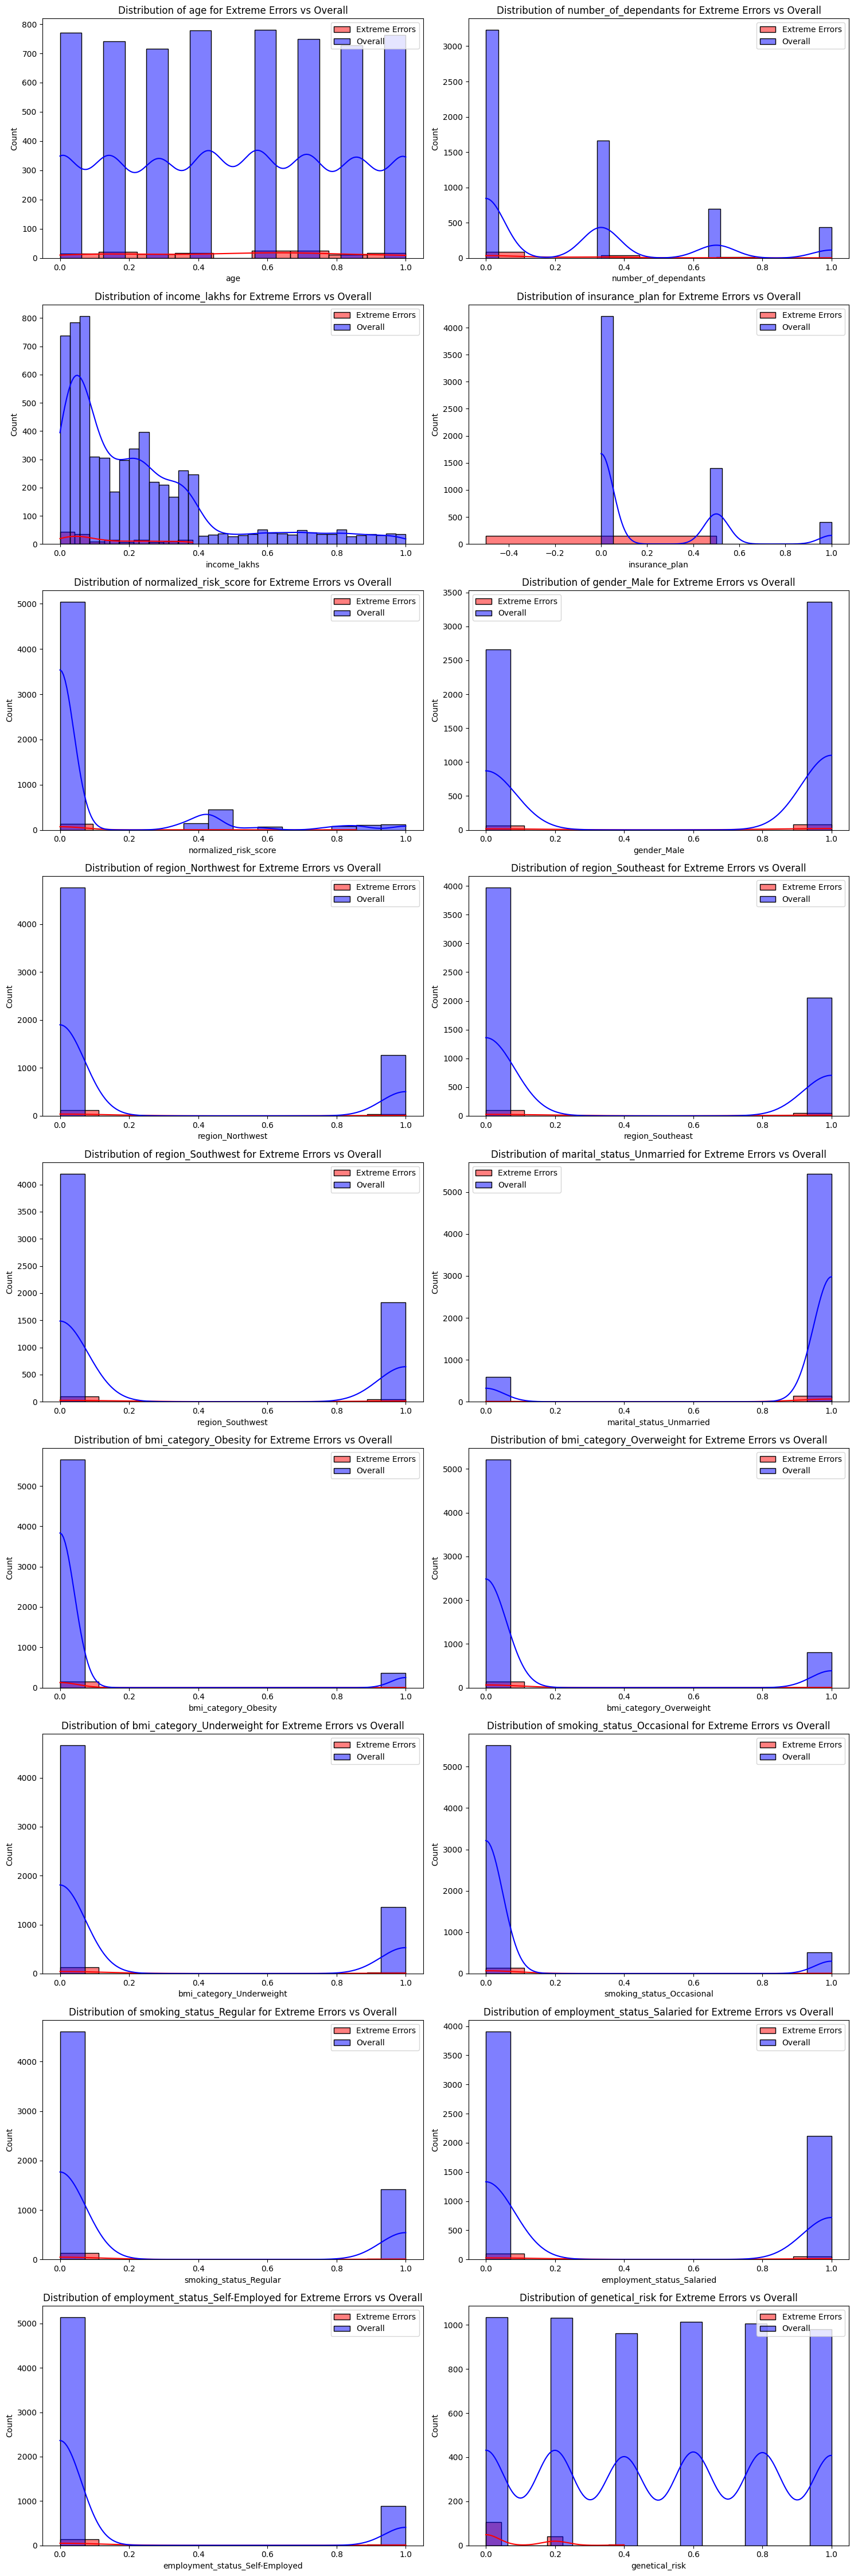

In [64]:
n_features = len(X_test.columns)

# Number of rows needed for subplots (2 charts per row)
n_rows = (n_features + 1) // 2  # Ceiling division to get the correct number of rows

# Create subplots with 2 columns
fig, axes = plt.subplots(n_rows, 2, figsize=(15, 5 * n_rows))

# Flatten axes for easier indexing
axes = axes.flatten()

# Loop through features and create a plot for each
for i, feature in enumerate(X_test.columns):
    ax = axes[i]
    sns.histplot(extreme_errors_df[feature], color='red', label='Extreme Errors', kde=True, ax=ax)
    sns.histplot(X_test[feature], color='blue', label='Overall', alpha=0.5, kde=True, ax=ax)
    ax.legend()
    ax.set_title(f'Distribution of {feature} for Extreme Errors vs Overall')

# Adjust layout
plt.tight_layout()
plt.show()

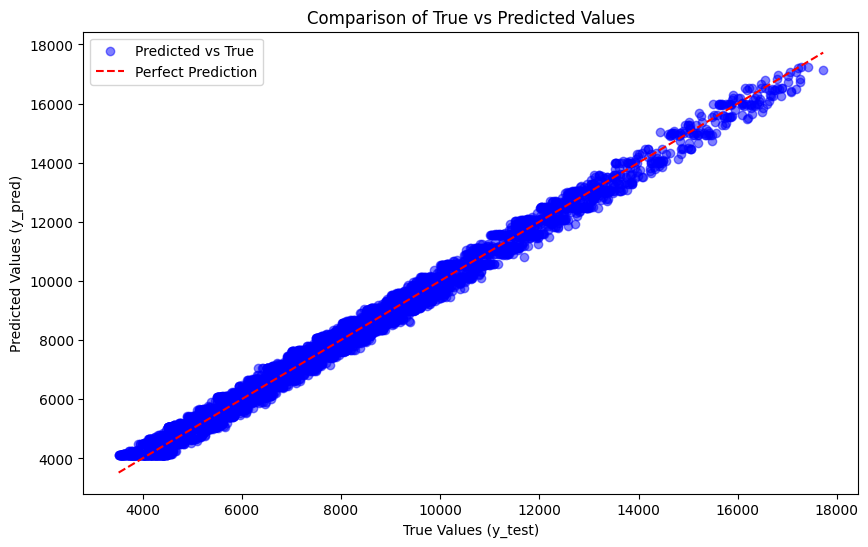

In [68]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label='Predicted vs True')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Prediction')  # Line of perfect prediction
plt.title('Comparison of True vs Predicted Values')
plt.xlabel('True Values (y_test)')
plt.ylabel('Predicted Values (y_pred)')
plt.legend(loc='upper left')
plt.show()

Results: After incorporating the genetical risk feature for the under-25 age group, the model's prediction error was reduced to ± 10%.

We have very few extreme errors (only 2%) which means this model looks good and no further investigation is required

Conclusion: The addition of the genetical risk feature for individuals under 25 significantly improved the accuracy of premium estimations, reducing errors in this segment

### Export the Model

In [ ]:
from joblib import dump

dump(best_model, "artifacts/model_young.joblib")
scaler_with_cols = {
    'scaler': scaler,
    'cols_to_scale': cols_to_scale
}
dump(scaler_with_cols, "artifacts/scaler_young.joblib")